In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
#dataset
input_path = r"C:\Users\giova\OneDrive\Desktop\ZEULI\3 Zeuli 220623\3 Zeuli 220623 ground truth.xlsx"

#alberi selezionati per far parte del test set
alberi_test_set = [147, 146, 60, 59, 141, 142, 36, 37]

df = pd.read_excel(input_path)
df

,ID_Pixel,ID_Albero,UTM_lon,UTM_lat,Red,Green,Blue,NIR,Rededge,NDVI,OSAVI,TCARI,TCARIOSAVI,EVI,MCARI,MCARIOSAVI,SR,TVI,NDRE,SWP
0,0_0,148,599776.152,4.565502e+06,10196,18429,13797,43737,17528,0.621901,0.721403,22925.347656,31778.822266,58.372780,12914.264648,17901.587891,0.233121,1.059198,0.427797,33.6
1,0_1,148,599776.232,4.565502e+06,9850,18950,13862,44370,17236,0.636665,0.738530,23957.542969,32439.509766,-174.696350,13524.222656,18312.359375,0.221997,1.066145,0.440444,33.6
2,0_2,148,599776.312,4.565502e+06,9384,19911,14077,44281,18330,0.650275,0.754317,28690.923828,38035.652344,-17.478212,18092.085938,23984.738281,0.211919,1.072509,0.414480,33.6
3,0_3,148,599776.392,4.565502e+06,9907,19974,13715,42230,19357,0.619963,0.719155,29073.322266,40427.078125,-67.934006,18705.189453,26009.968750,0.234596,1.058283,0.371393,33.6
4,0_4,148,599776.472,4.565502e+06,10355,20118,13217,39873,20283,0.587680,0.681707,29590.082031,43405.875000,25.654442,19381.968750,28431.529297,0.259700,1.042919,0.325653,33.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120093,90_39,59,599810.792,4.565672e+06,20656,35759,28383,40974,35076,0.329677,0.382424,43955.882812,114940.046875,-1.059079,24718.595703,64636.546875,0.504125,0.910866,0.077554,32.4
120094,90_40,59,599810.872,4.565672e+06,24906,34403,28565,43358,34811,0.270304,0.313551,29372.843750,93677.929688,-2.151335,13730.120117,43789.062500,0.574427,0.877669,0.109340,32.4
120095,91_38,59,599810.712,4.565672e+06,24335,35603,32737,37400,35067,0.211630,0.245491,32659.429688,133037.406250,-0.525826,15619.405273,63625.273438,0.650668,0.843582,0.032194,32.4
120096,91_39,59,599810.792,4.565672e+06,22815,35183,30407,40592,35091,0.280363,0.325221,36912.902344,113501.093750,-0.878840,18909.611328,58143.941406,0.562057,0.883382,0.072685,32.4


In [3]:
#estrazione del test set
df_test = df[df['ID_Albero'].isin(alberi_test_set)]
print(f"Valori unici ID_Albero in df_test = {df_test['ID_Albero'].unique()}")
df_test

Valori unici ID_Albero in df_test = [141 142  37  36 147 146  60  59]


,ID_Pixel,ID_Albero,UTM_lon,UTM_lat,Red,Green,Blue,NIR,Rededge,NDVI,OSAVI,TCARI,TCARIOSAVI,EVI,MCARI,MCARIOSAVI,SR,TVI,NDRE,SWP
5096,16_29,141,599818.072,4.565721e+06,15466,24169,19455,23231,25740,0.200662,0.232766,29253.234375,125676.343750,-0.649584,16576.054688,71213.250000,0.665748,0.837055,-0.051234,28.2
5097,16_31,141,599818.232,4.565721e+06,17761,22861,18666,27725,23190,0.219056,0.254105,16029.260742,63081.359375,-4.367877,7002.567871,27557.820312,0.640613,0.847972,0.089070,28.2
5098,16_32,141,599818.312,4.565721e+06,17562,25010,20422,26596,22997,0.204584,0.237316,17886.583984,75370.312500,-1.065531,7644.191406,32211.017578,0.660325,0.839395,0.072571,28.2
5099,17_28,141,599817.992,4.565721e+06,16311,27786,22979,25915,25099,0.227443,0.263833,28844.816406,109329.968750,-0.494435,14349.715820,54389.460938,0.629404,0.852903,0.015996,28.2
5100,17_29,141,599818.072,4.565721e+06,15974,29479,22579,28439,24645,0.280661,0.325566,30487.792969,93645.601562,-0.691601,14869.386719,45672.464844,0.561693,0.883550,0.071472,28.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120093,90_39,59,599810.792,4.565672e+06,20656,35759,28383,40974,35076,0.329677,0.382424,43955.882812,114940.046875,-1.059079,24718.595703,64636.546875,0.504125,0.910866,0.077554,32.4
120094,90_40,59,599810.872,4.565672e+06,24906,34403,28565,43358,34811,0.270304,0.313551,29372.843750,93677.929688,-2.151335,13730.120117,43789.062500,0.574427,0.877669,0.109340,32.4
120095,91_38,59,599810.712,4.565672e+06,24335,35603,32737,37400,35067,0.211630,0.245491,32659.429688,133037.406250,-0.525826,15619.405273,63625.273438,0.650668,0.843582,0.032194,32.4
120096,91_39,59,599810.792,4.565672e+06,22815,35183,30407,40592,35091,0.280363,0.325221,36912.902344,113501.093750,-0.878840,18909.611328,58143.941406,0.562057,0.883382,0.072685,32.4


In [4]:
#estrazione di training e validation set
df_train_val = df.drop(df_test.index)
df_train_val

,ID_Pixel,ID_Albero,UTM_lon,UTM_lat,Red,Green,Blue,NIR,Rededge,NDVI,OSAVI,TCARI,TCARIOSAVI,EVI,MCARI,MCARIOSAVI,SR,TVI,NDRE,SWP
0,0_0,148,599776.152,4.565502e+06,10196,18429,13797,43737,17528,0.621901,0.721403,22925.347656,31778.822266,58.372780,12914.264648,17901.587891,0.233121,1.059198,0.427797,33.6
1,0_1,148,599776.232,4.565502e+06,9850,18950,13862,44370,17236,0.636665,0.738530,23957.542969,32439.509766,-174.696350,13524.222656,18312.359375,0.221997,1.066145,0.440444,33.6
2,0_2,148,599776.312,4.565502e+06,9384,19911,14077,44281,18330,0.650275,0.754317,28690.923828,38035.652344,-17.478212,18092.085938,23984.738281,0.211919,1.072509,0.414480,33.6
3,0_3,148,599776.392,4.565502e+06,9907,19974,13715,42230,19357,0.619963,0.719155,29073.322266,40427.078125,-67.934006,18705.189453,26009.968750,0.234596,1.058283,0.371393,33.6
4,0_4,148,599776.472,4.565502e+06,10355,20118,13217,39873,20283,0.587680,0.681707,29590.082031,43405.875000,25.654442,19381.968750,28431.529297,0.259700,1.042919,0.325653,33.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107187,97_11,53,599749.752,4.565533e+06,18272,18006,14512,35151,22433,0.315950,0.366501,9221.916016,25162.050781,1.173979,4021.537598,10972.788086,0.519814,0.903300,0.220860,34.6
107188,97_12,53,599749.832,4.565533e+06,20217,19524,14589,31291,21916,0.214996,0.249394,3541.188477,14199.157227,0.641205,1323.177002,5305.562988,0.646096,0.845574,0.176199,34.6
107189,97_17,53,599750.232,4.565533e+06,18608,19243,17495,33110,21892,0.280405,0.325269,7982.097656,24539.980469,2.676337,3240.270020,9961.813477,0.562005,0.883406,0.203956,34.6
107190,97_18,53,599750.312,4.565533e+06,19298,19337,17386,36326,22738,0.306127,0.355106,7915.648926,22290.939453,1.959945,3251.753174,9157.130859,0.531245,0.897846,0.230056,34.6


In [5]:
#check se training set e test set hanno record in comune
df_common = df_train_val.isin(df_test)
df_common['ID_Pixel'].unique()

array([False])

In [6]:
scaler = StandardScaler()
features = df_train_val.drop(['ID_Pixel', 'ID_Albero', 'UTM_lon', 'UTM_lat','NDVI', 'OSAVI', 
                          'TCARI', 'TCARIOSAVI', 'EVI', 'MCARI', 'MCARIOSAVI', 'SR',
                          'TVI', 'NDRE', 'SWP'], axis=1).columns.to_list()

#standartizzazione features del training set
train_val_df2 = df_train_val[features]
X_train_val = pd.DataFrame(scaler.fit_transform(train_val_df2[features]),
                                  columns=features,
                                  index=train_val_df2.index)

#standartizzazione features del test set
test_df2 = df_test[features]
X_test = pd.DataFrame(scaler.fit_transform(test_df2[features]),
                                  columns=features,
                                  index=test_df2.index)
X_train_val.describe()

,Red,Green,Blue,NIR,Rededge
count,8.788300e+04,8.788300e+04,8.788300e+04,8.788300e+04,8.788300e+04
mean,-1.623488e-16,1.820764e-16,-9.314034e-17,3.182295e-16,1.170722e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-1.984744e+00,-2.827774e+00,-2.429495e+00,-2.931400e+00,-2.385871e+00
25%,-6.835721e-01,-7.167528e-01,-6.762146e-01,-6.630700e-01,-7.193218e-01
50%,-2.689924e-01,-1.598891e-01,-2.180509e-01,1.897798e-01,-2.336446e-01
75%,3.941437e-01,5.833501e-01,4.117773e-01,7.785583e-01,5.073870e-01
max,4.507714e+00,7.801801e+00,1.153545e+01,2.269890e+00,5.036798e+00


In [7]:
X_test.describe()

,Red,Green,Blue,NIR,Rededge
count,3.221500e+04,3.221500e+04,3.221500e+04,3.221500e+04,3.221500e+04
mean,8.469608e-17,1.835082e-16,2.823203e-17,3.317263e-16,2.470302e-16
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,-1.766912e+00,-1.935750e+00,-1.921052e+00,-3.235779e+00,-2.062795e+00
25%,-8.122158e-01,-9.304501e-01,-9.166108e-01,-4.869293e-01,-8.969906e-01
50%,-9.098153e-02,-4.333557e-02,-2.334347e-02,2.347364e-01,-5.208186e-02
75%,5.991245e-01,7.650295e-01,7.235527e-01,7.071701e-01,7.510932e-01
max,4.050039e+00,3.595521e+00,5.121821e+00,2.053314e+00,3.402804e+00


In [8]:
y_train_val = df_train_val['SWP']
y_test = df_test['SWP']

print(f"y_train = {y_train_val}")
print(f"y_test = {y_test}")

y_train = 0         33.6
1         33.6
2         33.6
3         33.6
4         33.6
          ... 
107187    34.6
107188    34.6
107189    34.6
107190    34.6
107191    34.6
Name: SWP, Length: 87883, dtype: float64
y_test = 5096      28.2
5097      28.2
5098      28.2
5099      28.2
5100      28.2
          ... 
120093    32.4
120094    32.4
120095    32.4
120096    32.4
120097    32.4
Name: SWP, Length: 32215, dtype: float64


In [11]:
print(f"X_train shape: {X_train_val.shape}")
print(f"y_train shape: {y_train_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (87883, 5)
y_train shape: (87883,)
X_test shape: (32215, 5)
y_test shape: (32215,)


In [18]:
training_set_df = pd.concat([X_train_val, y_train_val], axis=1)
test_set_df = pd.concat([X_test, y_test], axis=1)

,Red,Green,Blue,NIR,Rededge,SWP
5096,0.884947,0.636531,0.789141,-1.793055,1.069610,28.2
5097,1.325931,0.477818,0.666803,-1.246424,0.702007,28.2
5098,1.287693,0.738577,0.939078,-1.383751,0.674185,28.2
5099,1.047314,1.075416,1.335552,-1.466585,0.977205,28.2
5100,0.982559,1.280845,1.273530,-1.159576,0.911757,28.2
...,...,...,...,...,...,...
120093,1.882205,2.042858,2.173465,0.365130,2.415467,32.4
120094,2.698841,1.878321,2.201685,0.655110,2.377265,32.4
120095,2.589124,2.023929,2.848571,-0.069597,2.414169,32.4
120096,2.297056,1.972966,2.487294,0.318665,2.417629,32.4


In [19]:
training_set_df.to_csv(r"C:\Users\giova\OneDrive\Desktop\ZEULI\traintest set\training_set.csv", index=False)
test_set_df.to_csv(r"C:\Users\giova\OneDrive\Desktop\ZEULI\traintest set\test_set.csv", index=False)

In [10]:
torch.manual_seed(42)

#configurazione device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#train/validation split
x_train, x_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

#passaggio da dataframe a np.ndarray
x_train = x_train.values
y_train = y_train.values
x_val = x_val.values
y_val = y_val.values

# Convert to 2D PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach().clone().detach().reshape(-1, 1)
x_val = torch.tensor(x_val, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach().reshape(-1, 1)

In [26]:
# Define the model
model = nn.Sequential(
    nn.Linear(5, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

#iperparametri
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 50
batch_size = 10
batch_start = torch.arange(0, len(x_train), batch_size)

#Variabili per mantenere il modello migliore
best_mse = np.inf
best_weights = None
history = []

  0%|          | 0/7031 [00:00<?, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

  0%|          | 0/7031 [00:00<?, ?batch/s]

MSE: 85.83
RMSE: 9.26


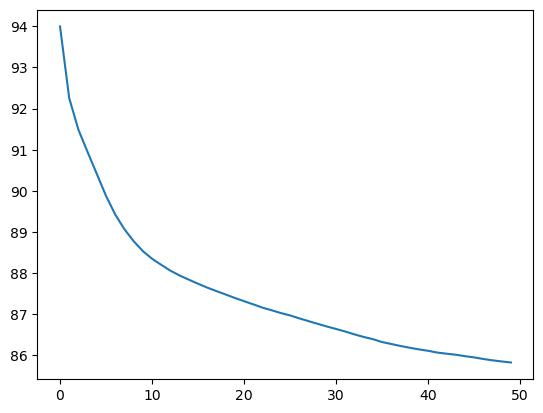

In [27]:
#ciclo di addestramento
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # prendi un batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            x_batch = torch.tensor(x_batch, dtype=torch.float32).clone().detach()
            y_batch = torch.tensor(y_batch, dtype=torch.float32).clone().detach().reshape(-1,1)
            #forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # aggiorna i pesi
            optimizer.step()
            # stampa il progresso
            bar.set_postfix(mse=float(loss))
    # valutazione del modello dopo ogni epoca
    model.eval()
    y_pred = model(x_val)
    mse = loss_fn(y_pred, y_val)
    mse = float(mse)
    history.append(mse)
    # se la loss è minore della best_loss finora, salva i pesi di questa epoca
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# recupara il modello migliore e mostra l'accuratezza migliore
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()